# Продолжение 4

# ВЫПУСКНАЯ КВАЛИФИКАЦИОННАЯ РАБОТА
слушателя курса "Data Science"

Образовательного центра

Московского государственного технического университета им. Н.Э. Баумана

Старостиной Ярославы Константиновны

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import tensorflow as tf

from numpy.random import seed
from pandas import read_excel, DataFrame, Series
from scipy import stats

from sklearn.preprocessing import Normalizer, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge, LassoLars, LinearRegression, LogisticRegression, SGDRegressor, PoissonRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import preprocessing

from tensorflow import keras as keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel(r"C:\Users\Ярослава\DS_FQW_Komposit\Датасет для ВКР_композиты\itog.xlsx")
df.shape

(1023, 15)

Прогнозируем величину "Прочность при растяжении, МПа"

В качестве метрики возьмём среднюю абсолютную ошибку (mae) и коэффициент детерминации (r2) в прогнозах. Для обучения используем 70 % данных, а для тестирования — 30 %.

In [3]:
# проведем предобработку данных, как уже выявлено из Приложения 2, 
# для прогнозирования данной величины будем использовать совокупность
# RobustScaler и StandartScaler
robust = RobustScaler().fit_transform(df)
df_rob = pd.DataFrame(robust, columns = df.columns)
std = StandardScaler().fit_transform(df_rob)
df_std = pd.DataFrame(std, columns = df.columns)
df_std.head()

,Unnamed: 0.1,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
0,-1.730359,-1.730359,-1.197501,0.779867,0.003103,0.000251,0.011062,-0.001329,-0.973486,-1.088651,1.148439,0.033133,-0.983518,-1.138798,-0.037245
1,-1.726972,-1.726972,-1.197501,0.779867,0.003103,-2.272468,0.636871,-0.033905,-0.973486,-1.088651,1.148439,0.033133,-0.983518,-1.138798,0.232119
2,-1.723586,-1.723586,-1.197501,0.779867,0.003103,-2.276220,-0.004609,-0.033905,-0.973486,-1.088651,1.148439,0.033133,-0.983518,-1.138798,1.129998
3,-1.720200,-1.720200,-1.197501,0.779867,0.003103,0.692038,-0.418711,0.357200,-0.973486,-1.088651,1.148439,0.033133,-0.983518,-0.742089,-0.935125
4,-1.716814,-1.716814,-0.172465,0.779867,0.046816,0.048853,0.011062,-0.033905,-0.973486,-1.088651,1.148439,0.033133,-0.983518,-0.742089,-0.037245


In [4]:
# разделим на тестовую и тренировочную выборки, 
# выделяя предикторы и целевые переменные
x_train, x_test, y_train, y_test = train_test_split(
    df_std.loc[:, df_std.columns != 'Прочность при растяжении, МПа'],
    df[['Прочность при растяжении, МПа']],
       test_size = 0.3,
    random_state = 26)
# Проверка правильности разбивки
df_std.shape[0] - x_train.shape[0] - x_test.shape[0]

0

In [5]:
x_train

,Unnamed: 0.1,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
124,-1.310467,-1.310467,0.408375,1.217873,-1.114237,0.394313,-0.531983,0.556528,-1.017909,0.758831,0.605316,-0.983518,-1.137361,-1.987316
134,-1.276605,-1.276605,0.050998,1.214225,-1.074787,-2.427705,-0.378864,0.496522,-0.398330,1.332006,0.683491,-0.983518,-0.068541,0.662923
532,0.071111,0.071111,0.498237,0.154091,2.306949,-1.287171,-0.682430,1.463227,-1.019347,-0.008721,-0.360668,-0.983518,0.488895,0.474341
537,0.088042,0.088042,1.506819,0.248115,-0.945138,2.068411,2.041864,0.316899,-0.284584,0.787457,1.884297,-0.983518,-0.452668,0.631448
81,-1.456075,-1.456075,0.881898,-1.960684,1.760809,0.185272,0.813209,-0.678531,-1.702665,0.576239,0.180715,-0.983518,-0.438854,1.431104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
961,1.523799,1.523799,-1.017126,-1.064931,-0.287143,0.313101,-0.655105,0.290523,-1.369541,-0.987801,-0.616972,1.016758,1.202382,0.925182
432,-0.267511,-0.267511,-0.794585,-0.810537,1.964243,0.038956,0.079706,-0.452603,-1.258783,0.299086,0.575065,-0.983518,-1.284860,-1.219672
774,0.890576,0.890576,0.481712,0.493389,0.558814,1.938230,-1.321466,1.452081,-1.004118,1.657251,1.049408,1.016758,-1.235363,0.330933
318,-0.653540,-0.653540,0.913426,0.659179,0.209521,-1.502921,1.166089,-0.186903,0.487465,0.779912,-0.843484,-0.983518,-2.224865,-1.002130


In [6]:
y_train

,"Прочность при растяжении, МПа"
124,2454.202188
134,2471.323296
532,2044.379328
537,2585.471946
81,2840.934853
...,...
961,2411.366964
432,2082.820982
774,2110.604619
318,2457.959767


In [7]:
x_test

,Unnamed: 0.1,Unnamed: 0,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
496,-0.050793,-0.050793,0.046749,-1.772355,1.624045,-0.635612,2.029226,-0.253191,0.045777,-0.994300,-0.265461,-0.983518,-0.091654,0.009128
842,1.120839,1.120839,-0.675381,-0.221635,-0.949251,1.535397,-0.479927,1.163582,-1.607113,-0.415572,1.853594,1.016758,0.680033,-1.211795
181,-1.117453,-1.117453,0.151160,0.591256,0.491119,0.399364,0.514570,-1.073979,-0.462799,1.146045,0.542576,-0.983518,-0.435232,0.727974
101,-1.388350,-1.388350,0.204897,0.190982,-1.718356,-2.194626,-2.222876,0.155680,1.124642,0.589236,-0.782153,-0.983518,0.133295,-1.438975
944,1.466233,1.466233,-0.591865,-2.188587,-0.470049,0.073639,0.564933,-0.949363,1.096575,-0.243281,-1.709747,1.016758,-0.883042,0.726373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,0.413119,0.413119,-1.229332,-0.765648,-1.098367,-0.264491,-1.791575,-0.728679,-1.592935,2.337611,-1.077799,1.016758,-1.033907,-0.556272
528,0.057566,0.057566,0.624604,-0.034722,1.245782,0.872948,0.345436,0.952354,-1.722170,-1.197702,-0.905493,-0.983518,-0.066365,-0.253799
482,-0.098200,-0.098200,0.348782,0.731909,-0.595525,0.700301,-0.307636,-0.731339,-1.686208,-0.610396,-0.582747,-0.983518,-0.243615,1.133503
700,0.639996,0.639996,-0.189484,0.484655,0.117315,-0.133948,1.127983,1.506637,-0.836021,1.586148,1.144473,1.016758,0.488242,0.725696


In [8]:
y_test

,"Прочность при растяжении, МПа"
496,2294.627295
842,2342.254202
181,2742.299965
101,2371.373132
944,2611.787961
...,...
633,2001.811014
528,1676.226034
482,1894.663766
700,2096.056525


In [9]:
# Метод линейной регрессии - Linear Regression

In [10]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
y_pred_lin_reg = lin_reg.predict(x_test)
mae_lin_reg = mean_absolute_error(y_pred_lin_reg, y_test)
r2_score_lin_reg = r2_score(y_test, y_pred_lin_reg)
print('mean absolute error:', round(mae_lin_reg, 2))
print("r2 score: ", round(r2_score_lin_reg, 2))

mean absolute error: 373.76
r2 score:  -0.0


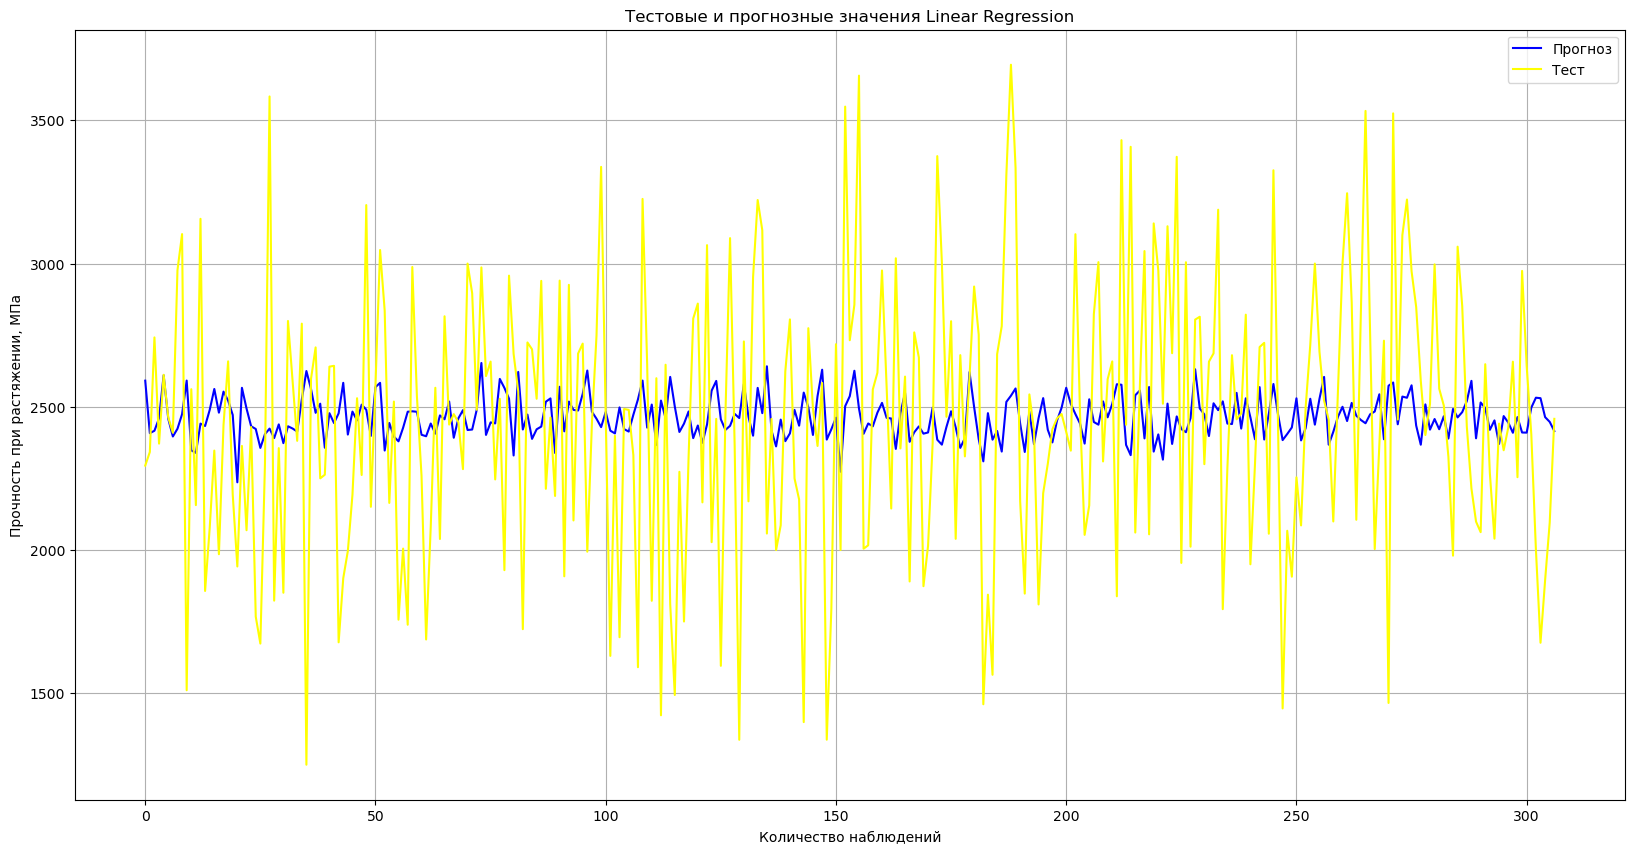

In [11]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Linear Regression")
plt.plot(y_pred_lin_reg, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [12]:
# Метод опорных векторов

In [13]:
svr_rbf = SVR(kernel="rbf", C=300, gamma=0.3, epsilon=0.5)
svr_rbf.fit(x_train, y_train)
y_pred_svr_rbf = svr_rbf.predict(x_test)
mae_svr_rbf = mean_absolute_error(y_pred_svr_rbf, y_test)
r2_score_svr_rbf = r2_score(y_test, y_pred_svr_rbf)
print('mean absolute error:', round(mae_svr_rbf, 2))
print("r2 score: ", round(r2_score_svr_rbf, 2))
# нашла лучшие С начинала от 100, gamma и epsilon начинала с 0.1

mean absolute error: 379.1
r2 score:  -0.02


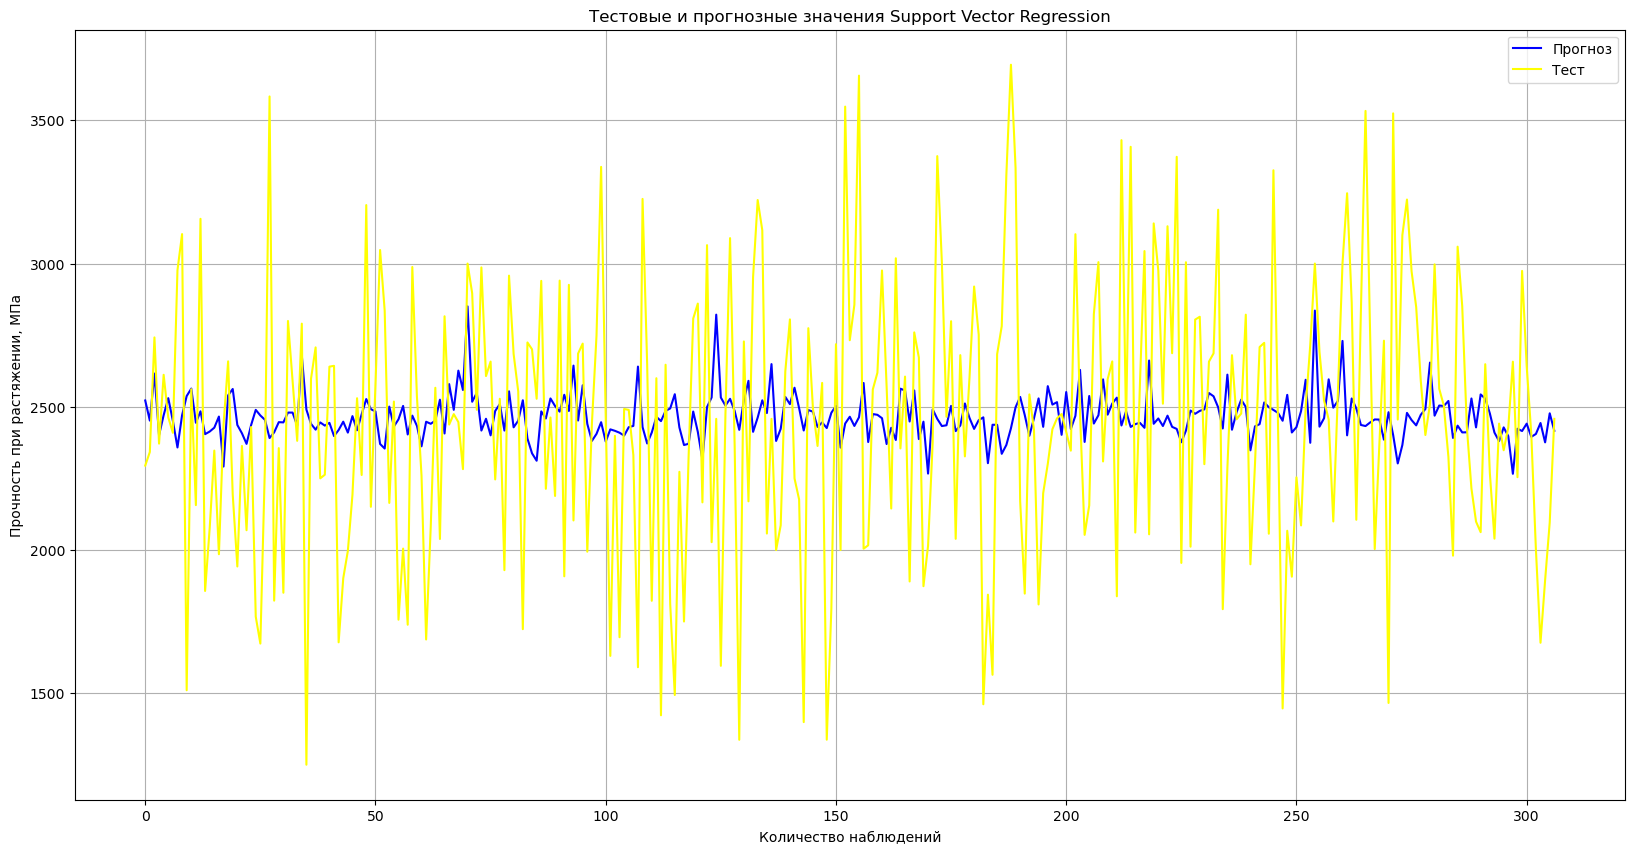

In [14]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Support Vector Regression")
plt.plot(y_pred_svr_rbf, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [15]:
svr_poly = SVR(kernel="poly", C=300, gamma='auto', degree=2, epsilon=0.3, coef0=0.3)
svr_poly.fit(x_train, y_train)
y_pred_svr_poly = svr_poly.predict(x_test)
mae_svr_poly = mean_absolute_error(y_pred_svr_poly, y_test)
r2_score_svr_poly = r2_score(y_test, y_pred_svr_poly)
print('mean absolute error:', round(mae_svr_poly, 2))
print("r2 score: ", round(r2_score_svr_poly, 2))
# нашла лучший gamma (начинала с 0.1, использовала 'scale'), degree (начинала с 1), epsilon и coef0 (начинала с 0.1 и 0.0)  

mean absolute error: 385.07
r2 score:  -0.08


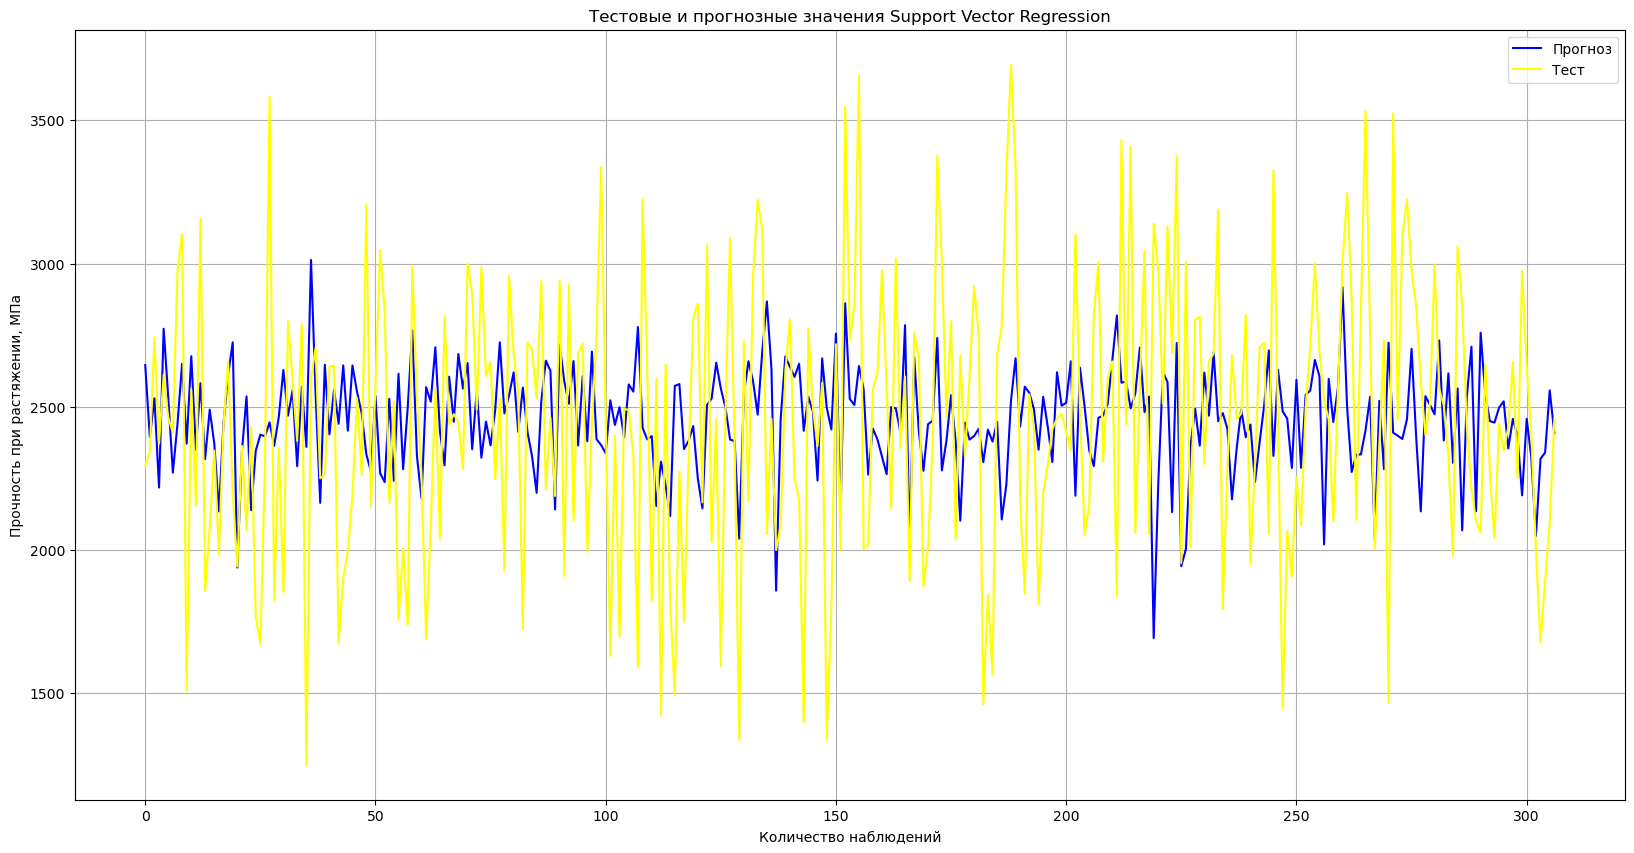

In [16]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Support Vector Regression")
plt.plot(y_pred_svr_poly, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [17]:
# Метод К ближайших соседей - K Neighbors Regressor

In [18]:
knr = KNeighborsRegressor(n_neighbors=5) # как по умолчанию
knr.fit(x_train, y_train.values)
y_pred_knr = knr.predict(x_test)
mae_knr = mean_absolute_error(y_pred_knr, y_test)
r2_score_knr = r2_score(y_test, y_pred_knr)
print('mean absolute error:', round(mae_knr, 2))
print("r2 score: ", round(r2_score_knr, 2))

mean absolute error: 412.88
r2 score:  -0.23


In [19]:
# Проведем поиск  по сетке гиперпараметров с перекрестной проверкой, количество блоков равно 10 (cv = 10), для 
# модели случайного леса - K Neighbors Regressor
parametrs_knr = { 'n_neighbors' : range(1, 501, 2),
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute']}
grid_knr = GridSearchCV(estimator = knr, param_grid = parametrs_knr, cv = 10, verbose = 1, scoring = 'r2')
grid_knr.fit(x_train, y_train)
grid_knr.best_params_

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits


{'algorithm': 'auto', 'n_neighbors': 385, 'weights': 'uniform'}

In [20]:
# подставим эти значения
knr = KNeighborsRegressor(n_neighbors=385, algorithm='auto', weights='uniform')
knr.fit(x_train, y_train.values)
y_pred_knr = knr.predict(x_test)
mae_knr = mean_absolute_error(y_pred_knr, y_test)
r2_score_knr = r2_score(y_test, y_pred_knr)
print('mean absolute error:', round(mae_knr, 2))
print("r2 score: ", round(r2_score_knr, 2))

mean absolute error: 370.79
r2 score:  0.01


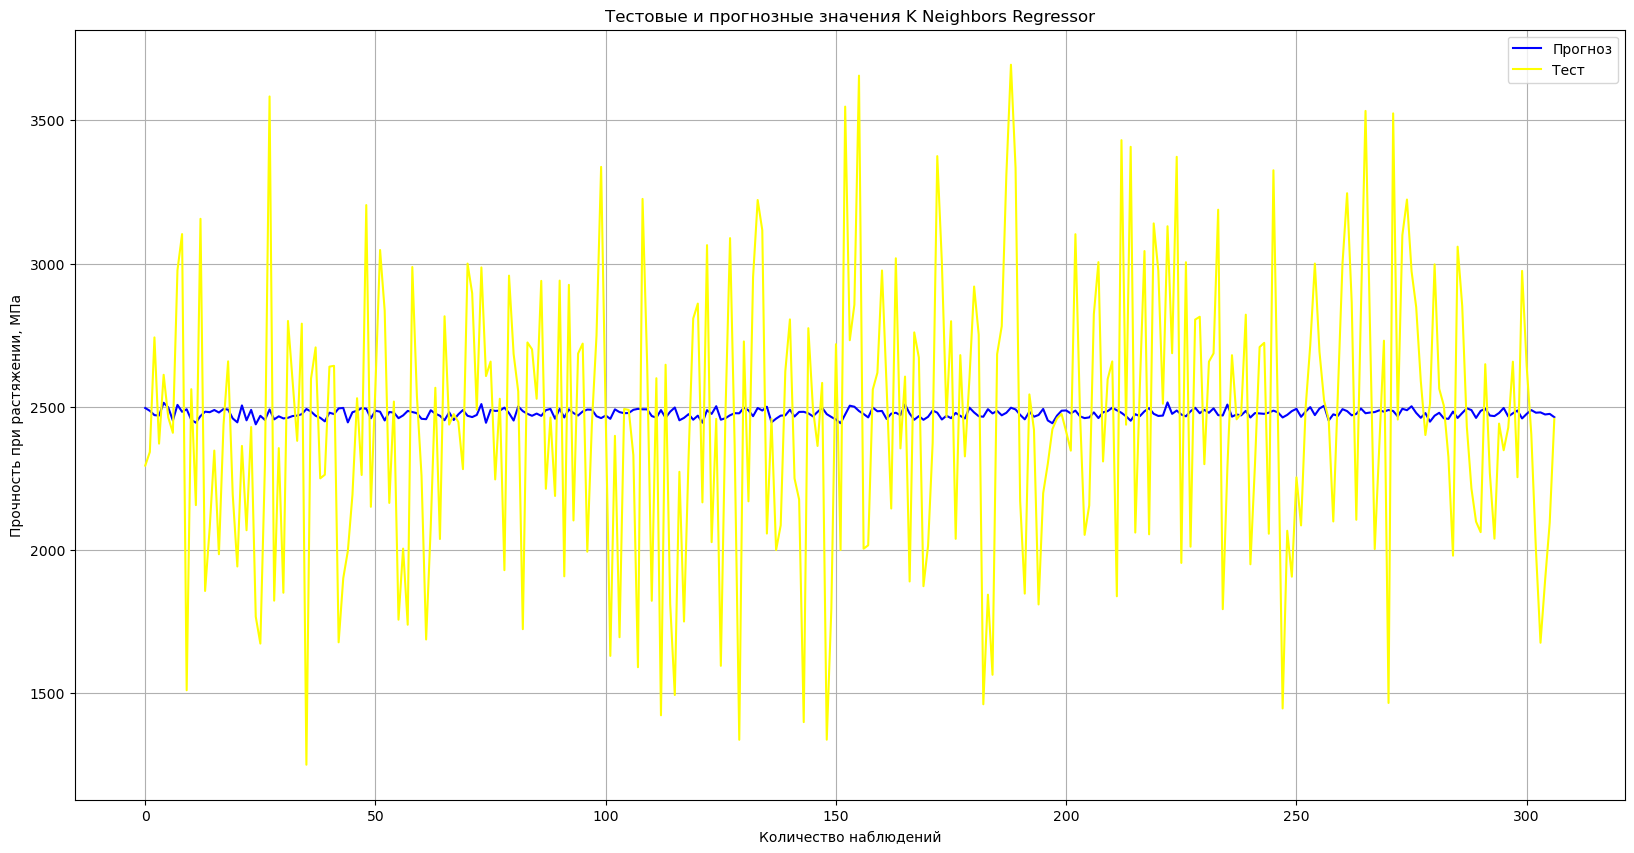

In [21]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения K Neighbors Regressor")
plt.plot(y_pred_knr, label = "Прогноз", color = 'blue')
plt.plot(y_test.values, label = "Тест", color = 'yellow')
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [22]:
#Деревья решений - Decision Tree Regressor

In [23]:
dtr = DecisionTreeRegressor()
dtr.fit(x_train, y_train.values)
y_pred_dtr = dtr.predict(x_test)
mae_dtr = mean_absolute_error(y_pred_dtr, y_test)
r2_score_dtr = r2_score(y_test, y_pred_dtr)
print('mean absolute error:', round(mae_dtr, 2))
print("r2 score: ", round(r2_score_dtr, 2))

mean absolute error: 521.13
r2 score:  -0.98


In [24]:
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
splitter = ['best', 'random']
max_depth = [3, 5, 7, 9, 11, 13, 15]
min_samples_leaf = [100, 150, 200, 250, 300]
min_samples_split = [100, 200, 300, 400]
max_features = ['auto', 'sqrt', 'log2']
param_grid_dtr = {'criterion': criterion,
               'splitter': splitter,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_features': max_features}
grid_dtr = GridSearchCV(dtr, param_grid_dtr, cv = 10, verbose = 1, scoring = 'r2')
grid_dtr.fit(x_train, y_train)
grid_dtr.best_params_

Fitting 10 folds for each of 3360 candidates, totalling 33600 fits


{'criterion': 'squared_error',
 'max_depth': 11,
 'max_features': 'auto',
 'min_samples_leaf': 200,
 'min_samples_split': 300,
 'splitter': 'random'}

In [25]:
# подставим эти значения
dtr = DecisionTreeRegressor(criterion='poisson',
                            max_depth=15, 
                            max_features='log2', 
                            min_samples_leaf=100,
                            min_samples_split=100,
                            splitter='best')
dtr.fit(x_train, y_train.values)
y_pred_dtr = dtr.predict(x_test)
mae_dtr = mean_absolute_error(y_pred_dtr, y_test)
r2_score_dtr = r2_score(y_test, y_pred_dtr)
print('mean absolute error:', round(mae_dtr, 2))
print("r2 score: ", round(r2_score_dtr, 2))

mean absolute error: 375.41
r2 score:  -0.01


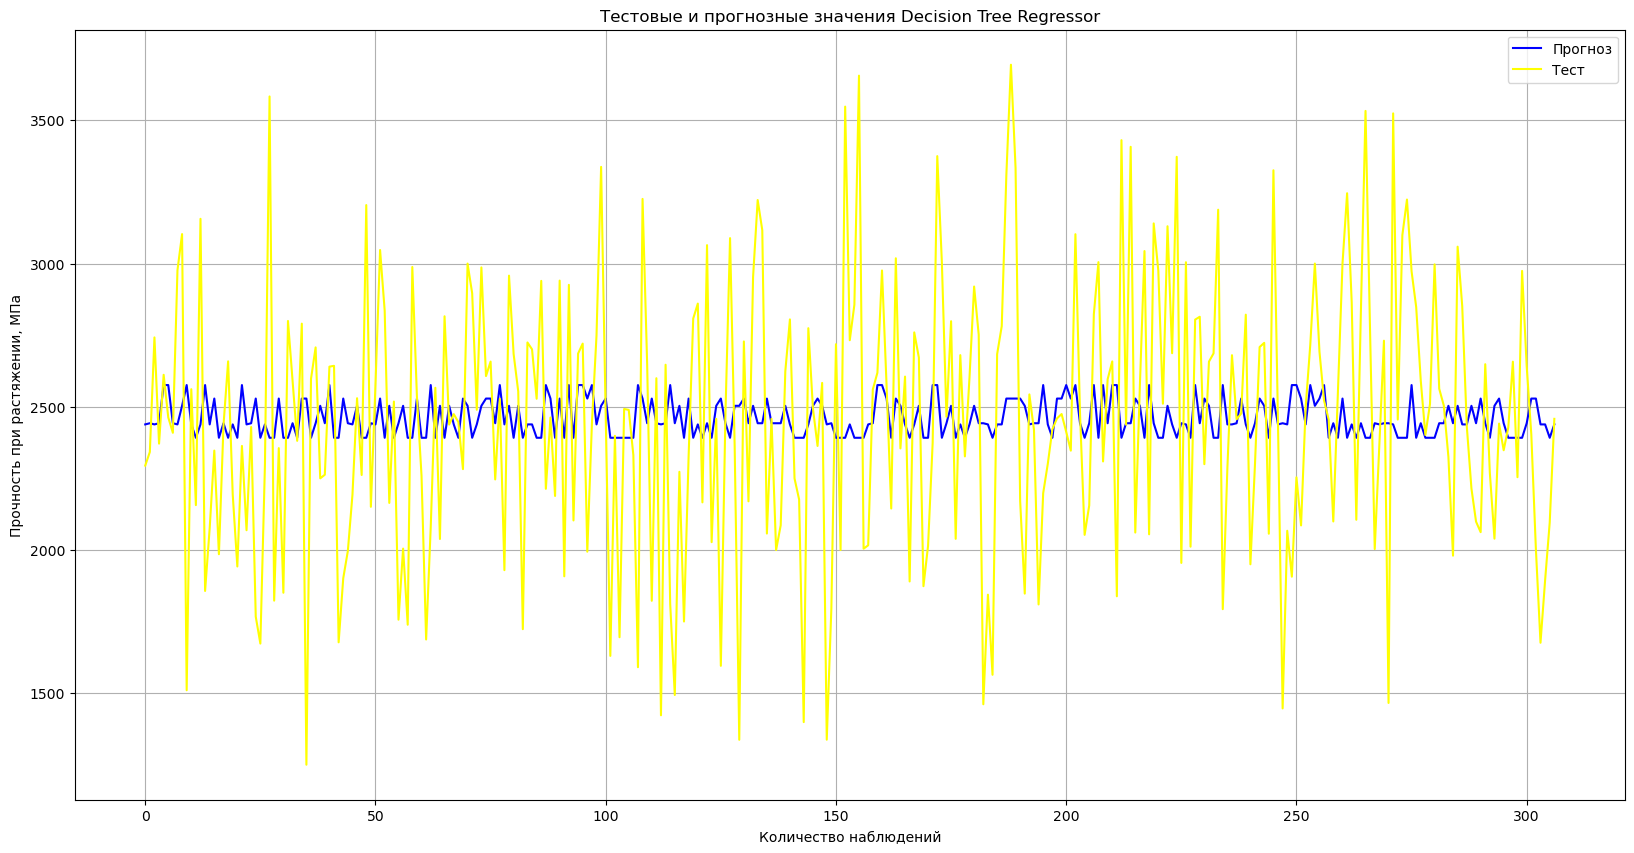

In [26]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Decision Tree Regressor")
plt.plot(y_pred_dtr, label = "Прогноз", color = 'blue')
plt.plot(y_test.values, label = "Тест", color = 'yellow')
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [27]:
# Метод случайного леса - Random Forest Regressor

In [28]:
rfr = RandomForestRegressor(random_state=26)
rfr.fit(x_train, y_train.values)
y_pred_rfr = rfr.predict(x_test)
mae_rfr = mean_absolute_error(y_pred_rfr, y_test)
r2_score_rfr = r2_score(y_test, y_pred_rfr)
print('mean absolute error:', round(mae_rfr, 2))
print("r2 score: ", round(r2_score_rfr, 2))

mean absolute error: 376.93
r2 score:  -0.03


In [29]:
# Проведем поиск  по сетке гиперпараметров с перекрестной проверкой, количество блоков равно 10 (cv = 10), для 
# модели случайного леса - Random Forest Regressor

parametrs_rfr = { 'n_estimators': [100, 500],
              'max_depth': [5, 15],
              'max_features': ['auto'],
              'criterion': ['mse'] }
grid_rfr = GridSearchCV(estimator = rfr, param_grid = parametrs_rfr, cv = 10)
grid_rfr.fit(x_train, y_train)
grid_rfr.best_params_

{'criterion': 'mse',
 'max_depth': 5,
 'max_features': 'auto',
 'n_estimators': 500}

In [30]:
# подставим эти значения
rfr = RandomForestRegressor(n_estimators = 500, max_depth = 5, max_features='auto', random_state=26)
rfr.fit(x_train, y_train.values)
y_pred_rfr = rfr.predict(x_test)
mae_rfr = mean_absolute_error(y_pred_rfr, y_test)
r2_score_rfr = r2_score(y_test, y_pred_rfr)
print('mean absolute error:', round(mae_rfr, 2))
print("r2 score: ", round(r2_score_rfr, 2))

mean absolute error: 373.21
r2 score:  -0.0


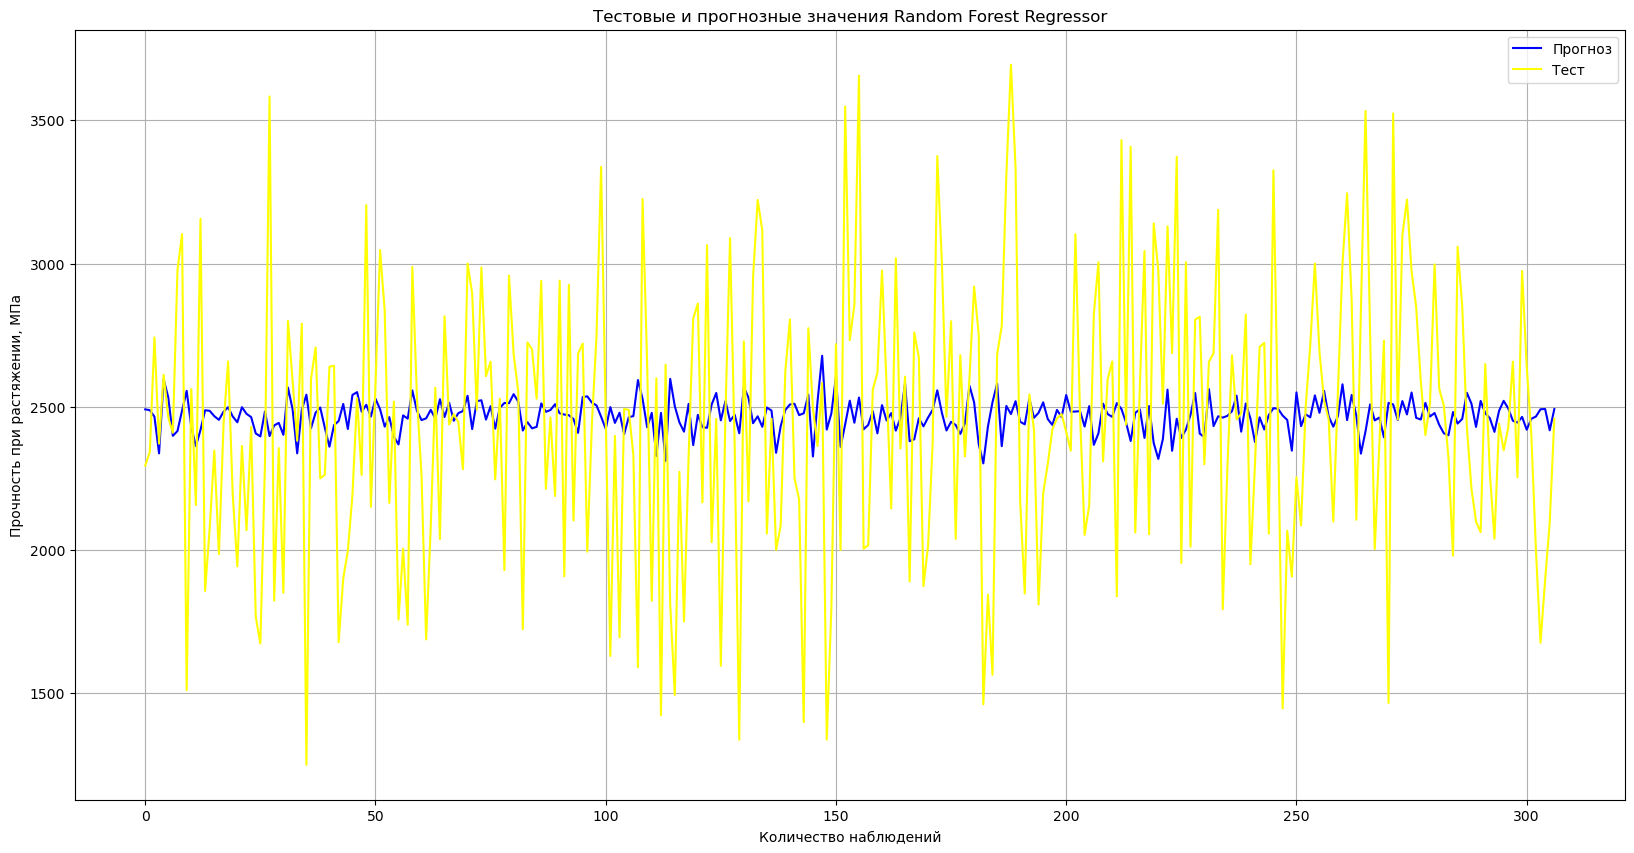

In [31]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Random Forest Regressor")
plt.plot(y_pred_rfr, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [32]:
# Модель Gradient Boosting Regressor

In [33]:
gbr = GradientBoostingRegressor(random_state=26)
gbr.fit(x_train, y_train.values)
y_pred_gbr = gbr.predict(x_test)
mae_gbr = mean_absolute_error(y_pred_gbr, y_test)
r2_score_gbr = r2_score(y_test, y_pred_gbr)
print('mean absolute error:', round(mae_gbr, 2))
print("r2 score: ", round(r2_score_gbr, 2))

mean absolute error: 381.59
r2 score:  -0.04


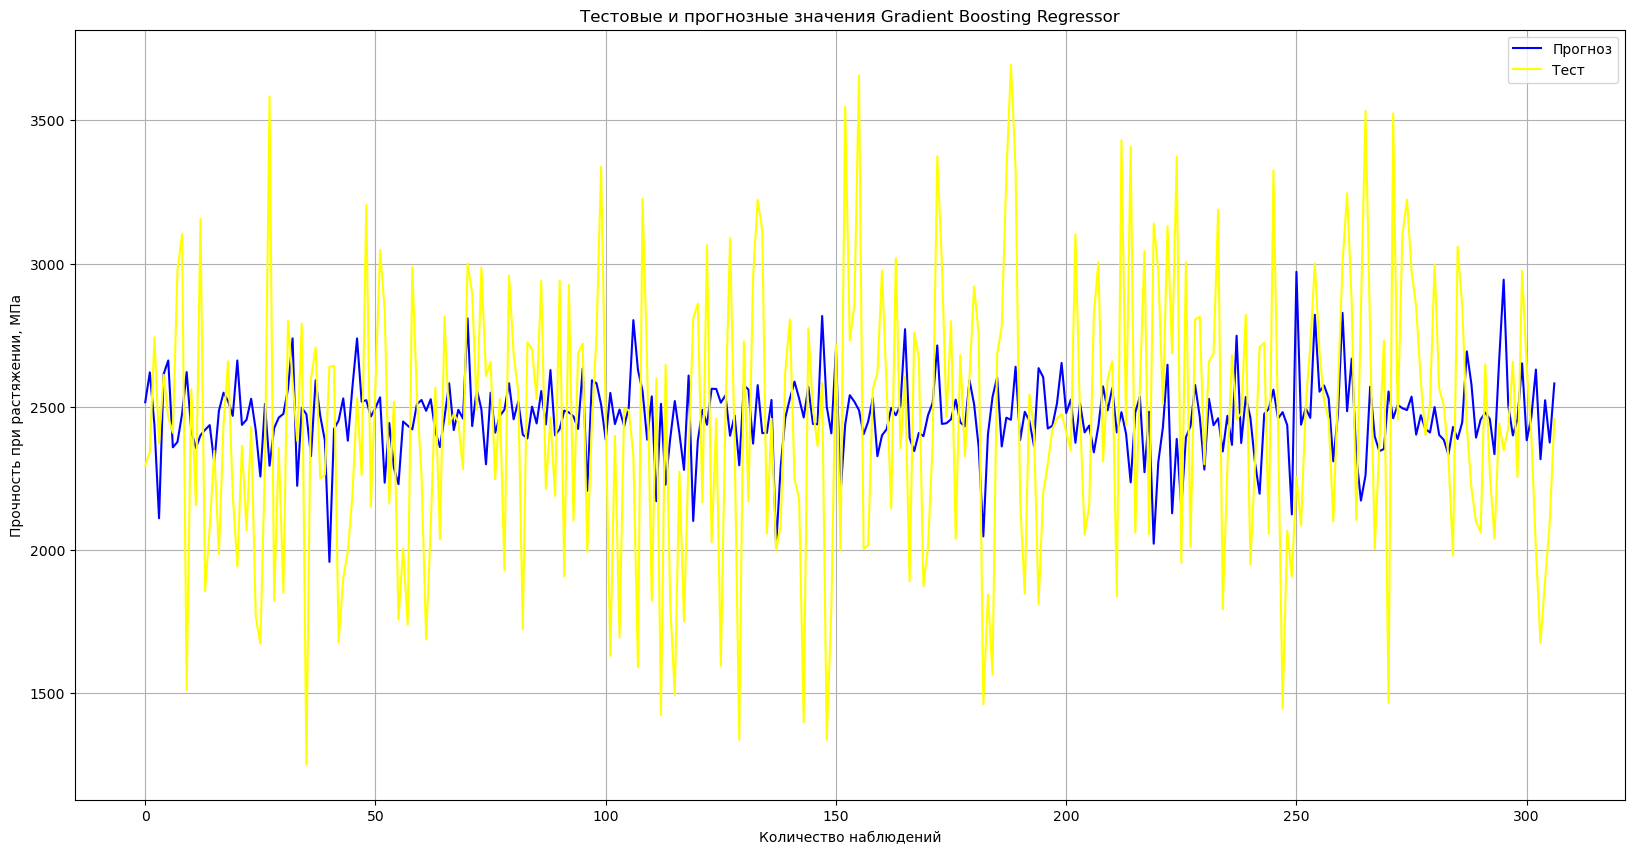

In [34]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Gradient Boosting Regressor")
plt.plot(y_pred_gbr, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [35]:
# Стохастический градиентный спуск (SGD) - Stochastic Gradient Descent Regressor

In [36]:
sgdr = SGDRegressor()
sgdr.fit(x_train, y_train.values)
y_pred_sgdr = sgdr.predict(x_test)
mae_sgdr = mean_absolute_error(y_pred_sgdr, y_test)
r2_score_sgdr = r2_score(y_test, y_pred_sgdr)
print('mean absolute error:', round(mae_sgdr, 2))
print("r2 score: ", round(r2_score_sgdr, 2))

mean absolute error: 373.76
r2 score:  0.0


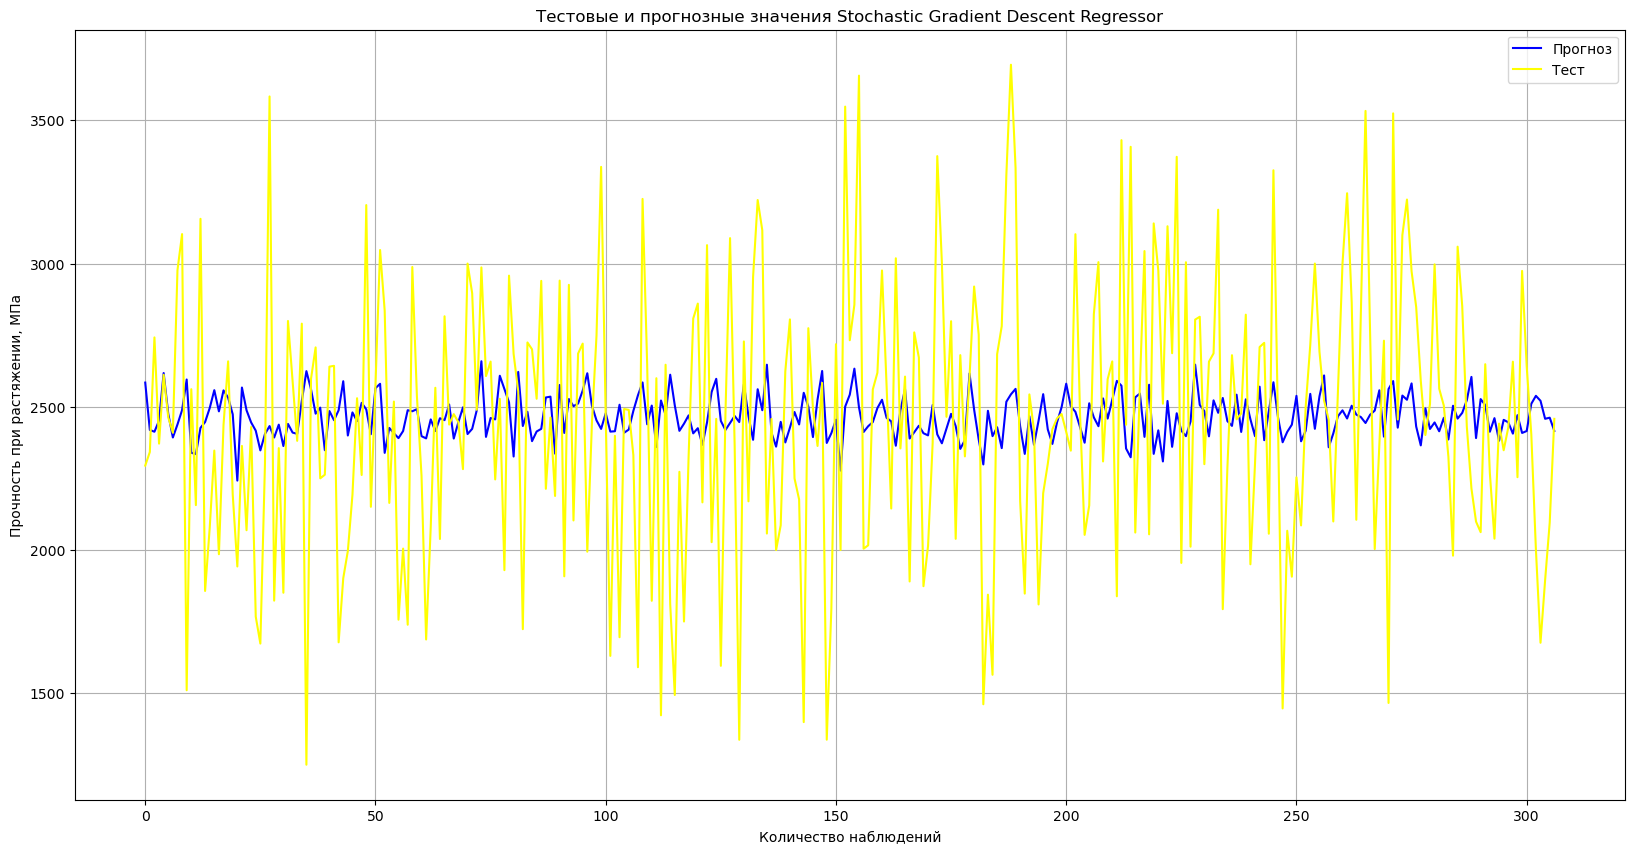

In [37]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Stochastic Gradient Descent Regressor")
plt.plot(y_pred_sgdr, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [38]:
# Модель Лассо соответствует регрессии с наименьшим углом, также известной как Ларс - LassoLars

In [39]:
ll = LassoLars(alpha=0)
ll.fit(x_train, y_train.values)
y_pred_ll = ll.predict(x_test)
mae_ll = mean_absolute_error(y_pred_ll, y_test)
r2_score_ll = r2_score(y_test, y_pred_ll)
print('mean absolute error:', round(mae_ll, 2))
print("r2 score: ", round(r2_score_ll, 2))

mean absolute error: 373.76
r2 score:  -0.0


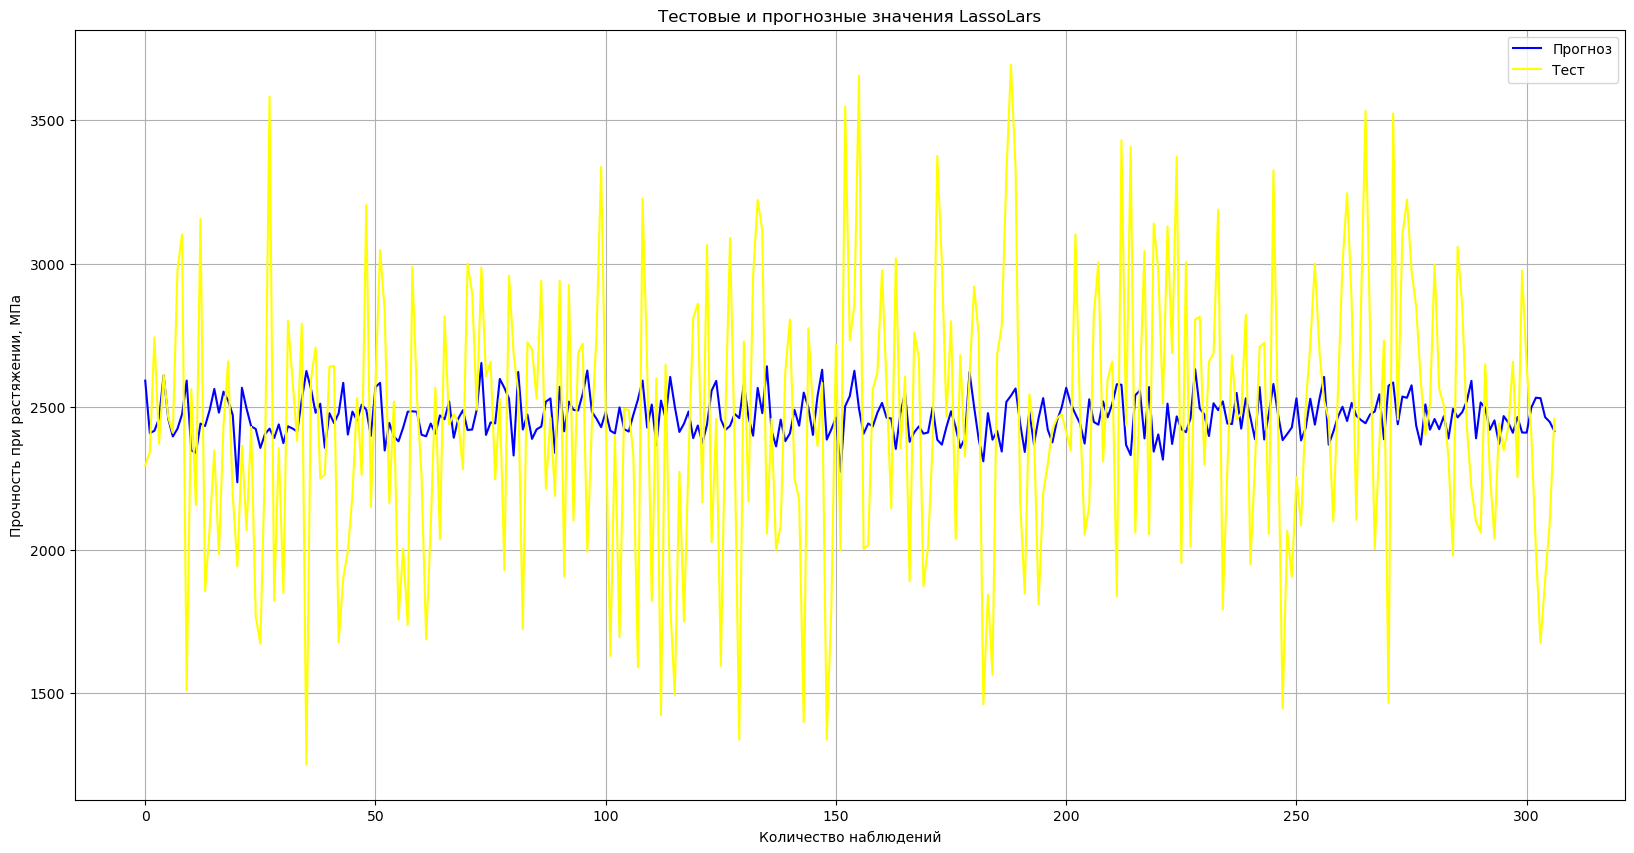

In [40]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения LassoLars")
plt.plot(y_pred_ll, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [41]:
# Модель регрессия байесовского гребня - Bayesian Ridge

In [42]:
br = BayesianRidge(n_iter = 5)
br.fit(x_train, y_train.values)
y_pred_br = br.predict(x_test)
mae_br = mean_absolute_error(y_pred_br, y_test)
r2_score_br = r2_score(y_test, y_pred_br)
print('mean absolute error:', round(mae_br, 2))
print("r2 score: ", round(r2_score_br, 2))

mean absolute error: 372.17
r2 score:  -0.0


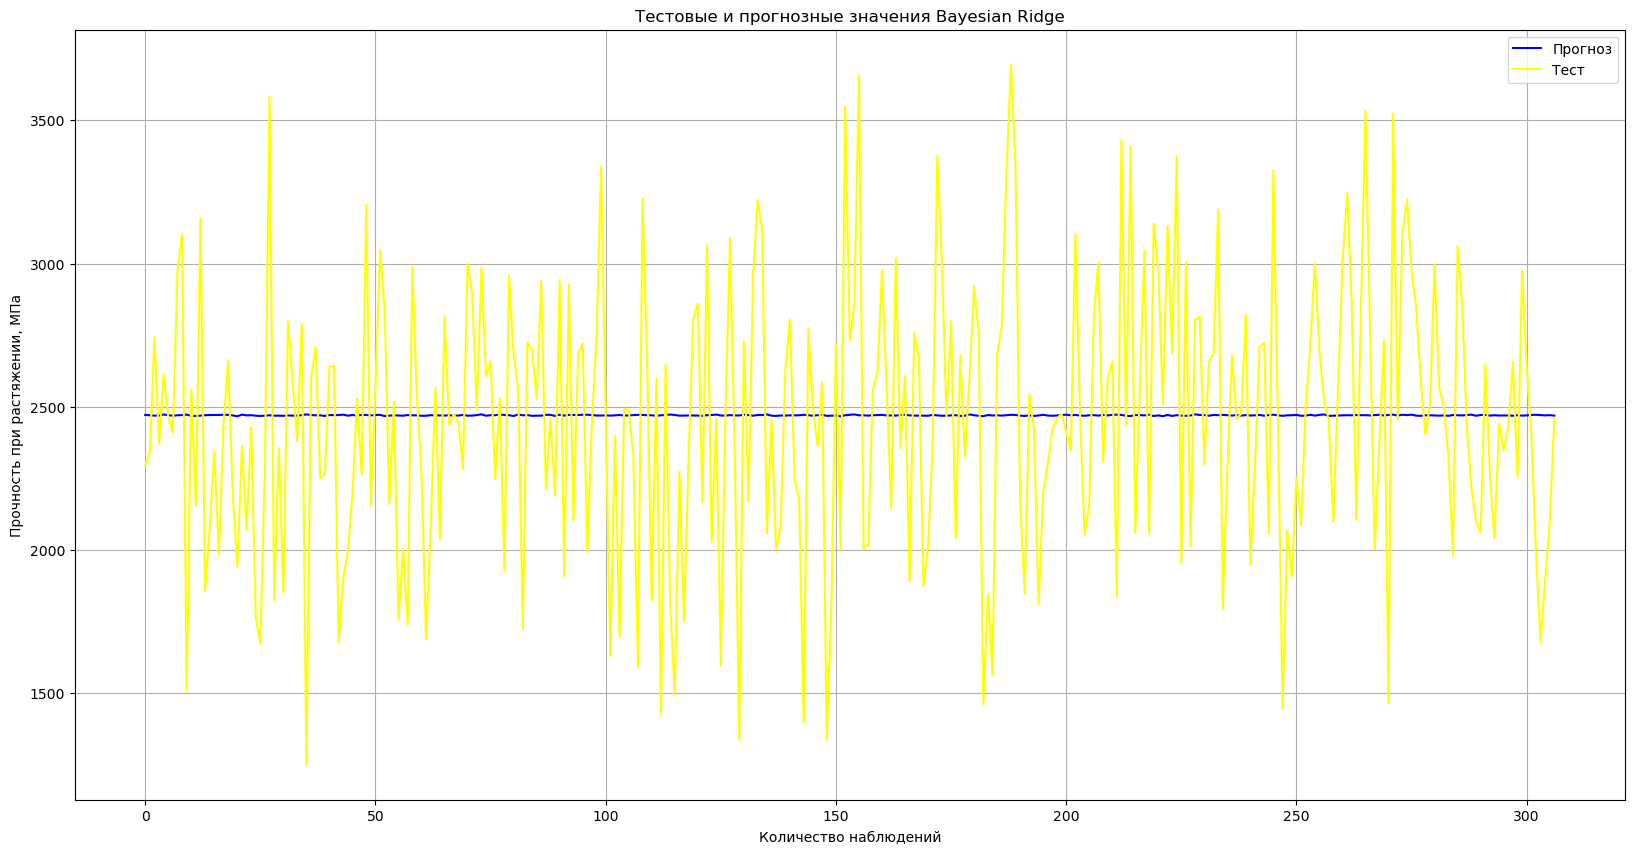

In [43]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Bayesian Ridge")
plt.plot(y_pred_br, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [44]:
# линейная модель с распределением Пуассона - Poisson Regressor

In [45]:
pr = PoissonRegressor(alpha = 1.0) # по умолчанию
pr.fit(x_train, y_train.values)
y_pred_pr = pr.predict(x_test)
mae_pr = mean_absolute_error(y_pred_pr, y_test)
r2_score_pr = r2_score(y_test, y_pred_pr)
print('mean absolute error:', round(mae_pr, 2))
print("r2 score: ", round(r2_score_pr, 2))

mean absolute error: 373.84
r2 score:  -0.0


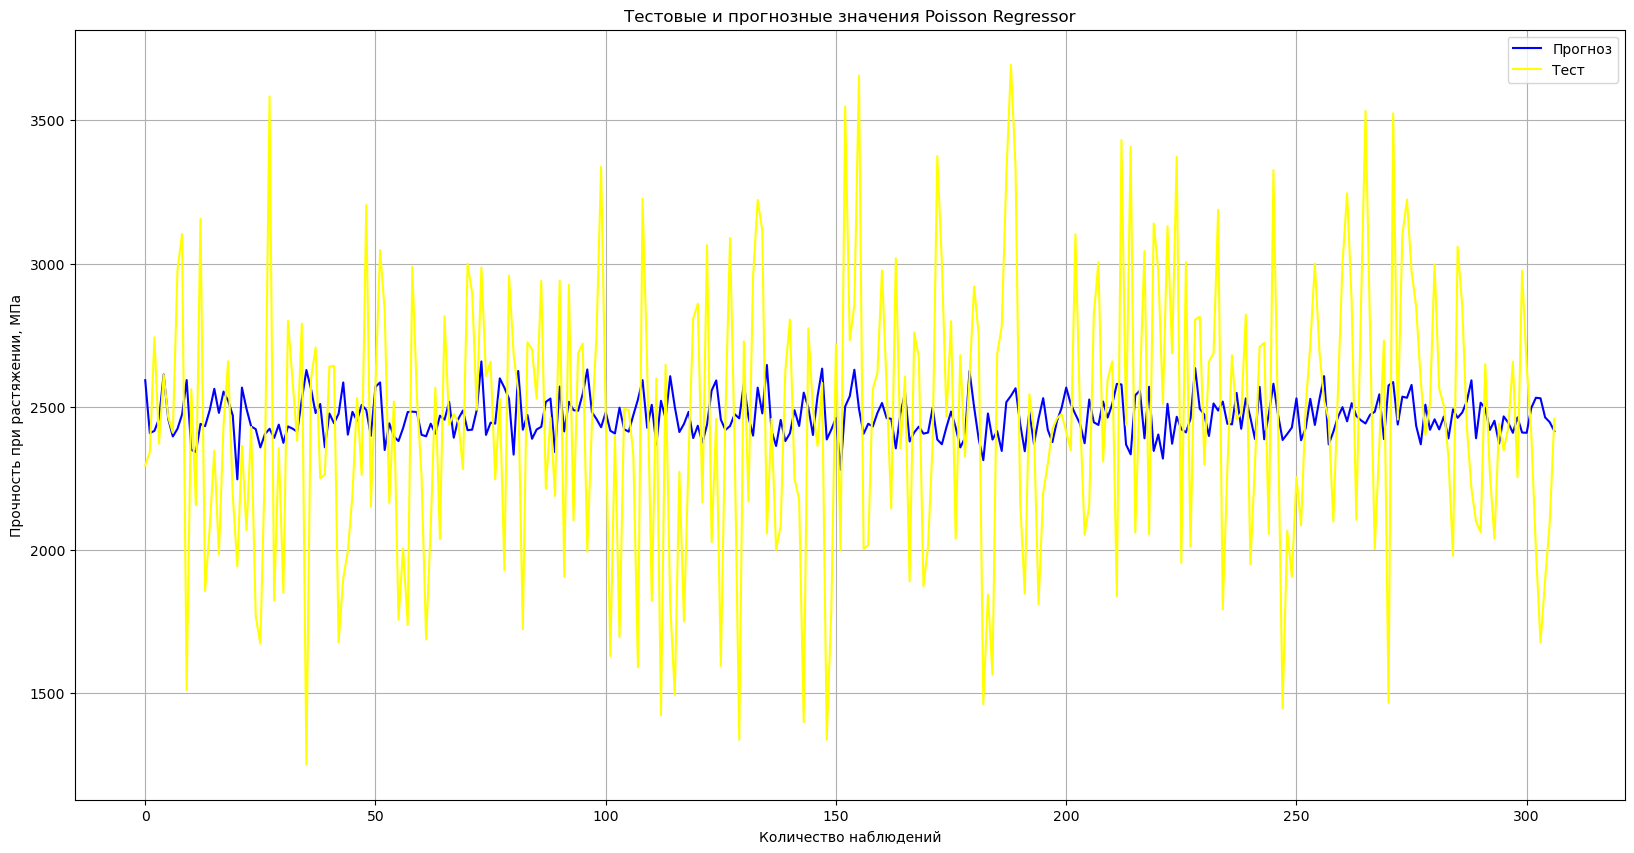

In [46]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Poisson Regressor")
plt.plot(y_pred_pr, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [47]:
# Многослойный перцептрон - Multi-layer Perceptron regressor

In [48]:
mlp = MLPRegressor(random_state = 26, max_iter = 2300)
mlp.fit(x_train, y_train.values)
y_pred_mlp = mlp.predict(x_test)
mae_mlp = mean_absolute_error(y_pred_mlp, y_test)
r2_score_mlp = r2_score(y_test, y_pred_mlp)
print('mean absolute error:', round(mae_mlp, 2))
print("r2 score: ", round(r2_score_mlp, 2))

mean absolute error: 425.34
r2 score:  -0.25


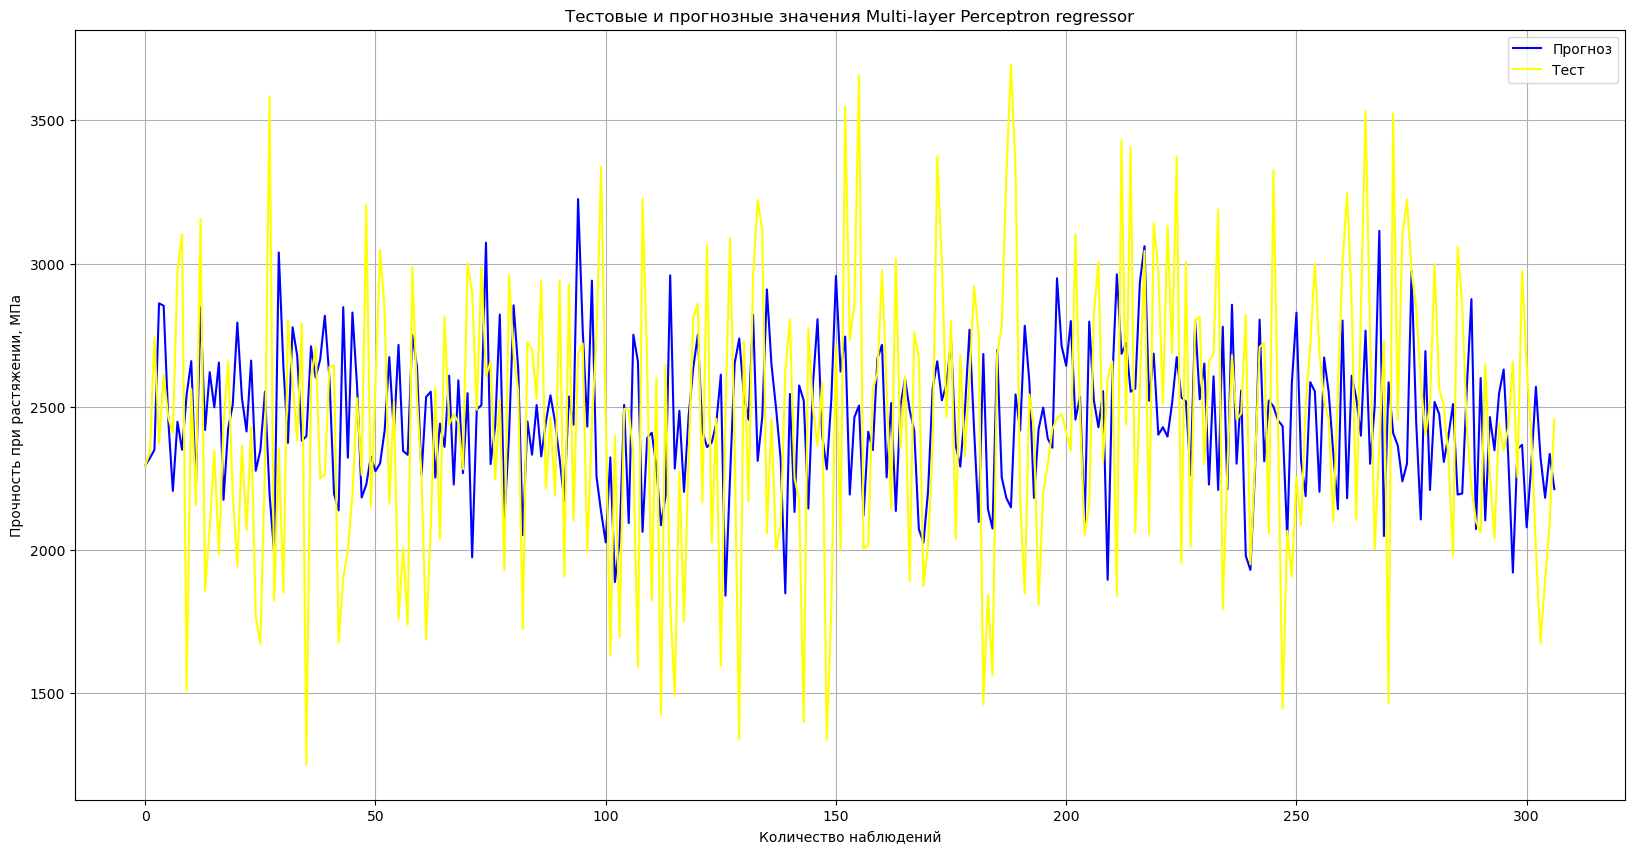

In [49]:
plt.figure(figsize = (20, 10))
plt.title("Тестовые и прогнозные значения Multi-layer Perceptron regressor")
plt.plot(y_pred_mlp, label = "Прогноз", color = "blue")
plt.plot(y_test.values, label = "Тест", color = "yellow")
plt.xlabel("Количество наблюдений")
plt.ylabel("Прочность при растяжении, МПа")
plt.legend()
plt.grid(True);

In [50]:
# сравним все модели по метрике МАЕ и R2
mae_r2_df = {'Регрессор': ['Linear Regression', 
                        'SVR rbf',
                        'SVR poly',
                        'K Neighbors Regressor',
                        'Decision Tree Regressor',
                        'Random Forest Regressor',
                        'Gradient Boosting Regressor',
                        'Stochastic Gradient Descent Regressor',
                        'Lasso Lars',
                        'Bayesian Ridge',
                        'Poisson Regressor',
                        'Multi-layer Perceptron regressor'], 
          'MAE': [mae_lin_reg, 
                  mae_svr_rbf,
                  mae_svr_poly,
                  mae_knr,
                  mae_dtr,
                  mae_rfr,
                  mae_gbr,
                  mae_sgdr,
                  mae_ll,
                  mae_br,
                  mae_pr,
                  mae_mlp],
          'R2 score': [r2_score_lin_reg, 
                       r2_score_svr_rbf,
                       r2_score_svr_poly,
                       r2_score_knr,
                       r2_score_dtr,
                       r2_score_rfr,
                       r2_score_gbr,
                       r2_score_sgdr,
                       r2_score_ll,
                       r2_score_br,
                       r2_score_pr,
                       r2_score_mlp]} 
mae_r2_df = pd.DataFrame.from_dict(mae_r2_df, orient='index')
mae_r2_df.T

,Регрессор,MAE,R2 score
0,Linear Regression,373.756781,-0.000892
1,SVR rbf,379.096126,-0.022535
2,SVR poly,385.073723,-0.075725
3,K Neighbors Regressor,370.785139,0.005681
4,Decision Tree Regressor,375.406146,-0.014831
5,Random Forest Regressor,373.208372,-0.002043
6,Gradient Boosting Regressor,381.594145,-0.044607
7,Stochastic Gradient Descent Regressor,373.756895,0.000256
8,Lasso Lars,373.756781,-0.000892
9,Bayesian Ridge,372.165846,-0.000703


In [51]:
# Применим библиотеку lazypredict
import lazypredict
from lazypredict.Supervised import LazyRegressor

reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(x_train, x_test, y_train, y_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [00:05<00:00,  8.39it/s]


In [52]:
print(models)

                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
LassoLarsIC                                 -0.04       0.01  469.13   
TweedieRegressor                            -0.04       0.01  470.05   
GammaRegressor                              -0.04       0.01  470.07   
ElasticNet                                  -0.04       0.01  470.10   
BayesianRidge                               -0.04       0.00  470.42   
LassoLars                                   -0.05       0.00  470.89   
Lasso                                       -0.05       0.00  471.09   
SVR                                         -0.05       0.00  471.25   
NuSVR                                       -0.05      -0.00  471.36   
QuantileRegressor                           -0.05      -0.00  471.36   
SGDRegressor                                -0.05      -0.00  471.41   
RidgeCV                                     -0.05      -0.00  47

In [53]:
# Пропустим через Pipeline

In [54]:
# Создаем пайплайн из моделей и препроцессоров
pipeline = Pipeline([('preprocessing', StandardScaler()), ('regressor', SVR())])
param_grid = [{'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [LinearRegression()]},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [SVR()],
                'regressor__kernel' : ['poly', 'rbf', 'sigmoid'],
                'regressor__gamma': ['scale', 'auto'],
                'regressor__C': [0.001, 0.01, 0.1, 1, 10, 100, 300]},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [KNeighborsRegressor()],
                'regressor__n_neighbors' : [3, 5, 7, 9, 13, 15],
                'regressor__weights' : ['uniform', 'distance']},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [DecisionTreeRegressor()],
                'regressor__criterion' : ['squared_error', 'friedman_mse', 'mean_absolute_error', 'poisson'],
                'regressor__splitter' : ['best', 'random']},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [RandomForestRegressor(random_state=26)],
                'regressor__n_estimators' : [50, 100, 150, 200],
                'regressor__criterion' : ['squared_error', 'friedman_mse', 'mean_absolute_error', 'poisson']},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [GradientBoostingRegressor(random_state=26)], 
                'regressor__n_estimators' : [50, 100, 150, 200],
                'regressor__criterion' : ['squared_error', 'friedman_mse', 'mean_absolute_error', 'poisson']},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [SGDRegressor()],
                'regressor__max_iter' : [500, 1000, 1500],
                'regressor__loss' : ['squared_error', 'huber', 'absolute_error', 'quantile']},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [LassoLars()],
                'regressor__alpha' : [0, 0.1, 0.5, 1, 1.5],
                'regressor__max_iter' : [100, 300, 500, 1000]},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [BayesianRidge()],
                'regressor__n_iter': [100, 300, 500, 1000]},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [PoissonRegressor()],
                'regressor__alpha' : [0, 0.1, 0.5, 1, 1.5],
                'regressor__max_iter' : [100, 300, 500, 1000]},
               {'preprocessing': [StandardScaler(), MinMaxScaler(), RobustScaler(), None],
                'regressor': [MLPRegressor(random_state=26)], 
                'regressor__activation' : ['identity', 'logistic', 'tanh', 'relu'],
                'regressor__max_iter' : [100, 500, 1000, 2000],
                'regressor__solver' : ['lbfgs', 'sgd', 'adam']}]
grid = GridSearchCV(pipeline, param_grid, cv=10)
grid.fit(x_train, np.ravel(y_train))
print("Наилучшие параметры:\n{}\n".format(grid.best_params_))
print("Наилучшее значение правильности перекрестной проверки: {:.2f}".format(grid.best_score_))
print("Правильность на тестовом наборе: {:.2f}".format(grid.score(x_test, y_test)))

Наилучшие параметры:
{'preprocessing': RobustScaler(), 'regressor': SVR(C=10, kernel='poly'), 'regressor__C': 10, 'regressor__gamma': 'scale', 'regressor__kernel': 'poly'}

Наилучшее значение правильности перекрестной проверки: -0.01
Правильность на тестовом наборе: -0.00
